## Problem set 7

**Problem 0** (-2 points for every missing green OK sign. If you don't run the cell below, that's -14 points.)

Make sure you are in the DATA1030 environment.

In [1]:
from __future__ import print_function
from distutils.version import LooseVersion as Version
import sys

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.7 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == min_ver:
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(sys.version)
if pyversion >= "3.7":
    print(OK, "Python version is %s" % sys.version)
elif pyversion < "3.7":
    print(FAIL, "Python version 3.7 is required,"
                " but %s is installed." % sys.version)
else:
    print(FAIL, "Unknown Python version: %s" % sys.version)

    
print()
requirements = {'numpy': "1.18.5", 'matplotlib': "3.2.2",'sklearn': "0.23.1", 
                'pandas': "1.0.5",'xgboost': "1.1.1", 'shap': "0.35.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:33:30) 
[Clang 9.0.1 ]

[ OK ] numpy version 1.18.5 is installed.
[ OK ] matplotlib version 3.2.2 is installed.
[ OK ] sklearn version 0.23.1 is installed.
[ OK ] pandas version 1.0.5 is installed.
[ OK ] xgboost version 1.1.1 is installed.
[ OK ] shap version 0.35.0 is installed.


**Problem 1**

We will investigate the importance of preprocessing your dataset in this exercise. You will work with the unprocessed diabetes dataset in problem 1a, and you will preprocess it in 1b. You'll train a regression model in both problems and you'll compare the feature coefficients. 

The feature coefficients are determined by two things:
- the importance of the feautre
- the value of the feature

So if a feature coefficient is large, there can be two reason for it: either the feature is important, or its value is small so it needs to be multiplied by a large number if it contributes to the prediction. The only way to remove this ambiguity is to standardize all features. If all features have a 0 mean and the same standard deviation, the feature coefficient is purely determined by the importance of the feature and it can be used to rank features based on how important they are.


**Problem 1a** (10 points)

First, read in the dataset into a pandas dataframe using the tab delimited file linked at [this page](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html). Loop through 10 different random states. Split the dataset into training and test sets (70-30 ratios). We won't tune the regularization parameter, that's why we won't need a validation set for this exercise. Do not preprocess the sets. Train a linear regression model with Ridge regularization with alpha = 1. Use RMSE as your evaluation metric and print out the mean and standard deviation of the training and test scores. For each random state, save the test score and the model's coefficients for each feature.

Once you loop through the 10 random states, prepare one plot which shows the mean and standard deviation of each feature's coefficient. Make sure to have proper x and y ticks and labels.

Hint: use plt.errorbar() for the figure.

53.33126606771177 0.8587287173176426
54.58524708995854 1.8947198577448843


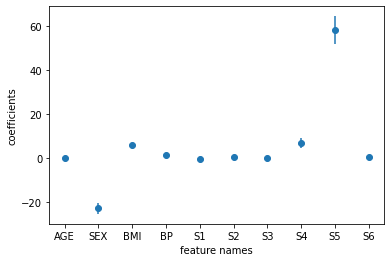

In [2]:
import pandas as pd
import numpy as np
from  sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

df = pd.read_csv("https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt", sep='\t')
df.head()

y = df['Y']
X = df.loc[:, df.columns != 'Y']

thetas = np.zeros([10,X.shape[1]])
train_scores = np.zeros(10)
test_scores = np.zeros(10)

for i in range(10):
    random_state = 42 * i
    
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=random_state)

    # load the linear regression model
    lin_reg = Ridge(alpha=1)
    lin_reg.fit(X_train, y_train)
    # train and test scores
    train_scores[i] = mean_squared_error(y_train,lin_reg.predict(X_train),squared=False)
    test_scores[i] = mean_squared_error(y_test,lin_reg.predict(X_test),squared=False)
    thetas[i] = lin_reg.coef_
    
print(np.mean(train_scores),np.std(train_scores))
print(np.mean(test_scores),np.std(test_scores))

plt.errorbar(np.arange(X.shape[1]),np.mean(thetas,axis=0),yerr=np.std(thetas,axis=0),fmt='o')
plt.xticks(np.arange(X.shape[1]),X.columns)
plt.ylabel('coefficients')
plt.xlabel('feature names')
plt.show()

**Problem 1b** (10 points)

Repeat what you did in 1a but this time preprocess the sets with the standard scaler.

Notice how the coefficients changed as a result of preprocessing. 

Answer the following questions:

Q1: Do you see a statistically significant change in the test score?

Q2: How would you order the features based on the coefficients for feature importance? Explain your answer in a few sentences.

Q3: Which are the top 3 most important features?

53.33225222444937 0.8621450587174802
54.56367414495442 1.9046784463244424


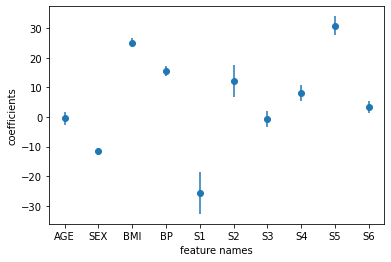

Index(['S5', 'S1', 'BMI'], dtype='object')


In [3]:
import pandas as pd
import numpy as np
from  sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
df = pd.read_csv("https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt", sep='\t')
df.head()

y = df['Y']
X = df.loc[:, df.columns != 'Y']

thetas = np.zeros([10,X.shape[1]])
train_scores = np.zeros(10)
test_scores = np.zeros(10)

for i in range(10):
    random_state = 42 * i
    
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=random_state)
    
    # preprocess the data
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)

    # load the linear regression model
    lin_reg = Ridge(alpha=1)
    lin_reg.fit(X_train, y_train)
    # train and test scores
    train_scores[i] = mean_squared_error(y_train,lin_reg.predict(X_train),squared=False)
    test_scores[i] = mean_squared_error(y_test,lin_reg.predict(X_test),squared=False)
    thetas[i] = lin_reg.coef_
    
print(np.mean(train_scores),np.std(train_scores))
print(np.mean(test_scores),np.std(test_scores))
plt.errorbar(np.arange(X.shape[1]),np.mean(thetas,axis=0),yerr=np.std(thetas,axis=0),fmt='o')
plt.xticks(np.arange(X.shape[1]),X.columns)
plt.ylabel('coefficients')
plt.xlabel('feature names')
plt.show()

print(X.columns[np.argsort(np.abs(np.mean(thetas,axis=0)))[::-1]][:3])


Problem 2:

In class we have seen both l1 (Lasso) and l2 (Ridge) regression. These are two basic ways to perform regularization. In the following problem, we will explore the **elastic net**, a third regularization technique that combines both l1 and l2 penalties. We will use this in a classification context. 

The basic idea of the elastic net is that the cost function in regression becomes

$L(\theta) = \frac{1}{n}\sum_{i=1}^{n}[(\theta_0 + \sum_{j=1}^{m} \theta_j  x_{ij}- y_i)^2] + \color{red}{ \frac{\alpha \rho}{m} \sum_{j=0}^{m}|\theta_j|} + \color{blue}{ \frac{\alpha (1-\rho)}{m} \sum_{j=0}^{m} \theta_j^2}$,

and the cost function in classification is

$L(\theta) = - \frac{1}{N}\sum_{i=1}^{n} [y_i\ln(\frac{1}{1+e^{-\theta_0 + \sum_{j=1}^{m} \theta_j  x_{ij}}}) + (1-y_i)\ln(1-\frac{1}{1+e^{-\theta_0 + \sum_{j=1}^{m} \theta_j  x_{ij}}}))] + \color{red}{ \frac{\alpha \rho}{m} \sum_{j=0}^{m}|\theta_j|} + \color{blue}{ \frac{\alpha (1-\rho)}{m} \sum_{j=0}^{m} \theta_j^2}$,


where $\alpha$ is the regularization parameter and $\rho$ is the l1 ratio (how much weight we assign to the l1 term over the l2 term in the cost function). Basically, an elastic net uses the weighted sum of the l1 and l2 regularization terms. The weight of the l1 term is $\rho$ and the weight of the l2 term is $(1-\rho)$ where $\rho$ is between 0 and 1.

You can read more about the elastic net [here](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net).

**Problem 2a** (3 points)

Load the training and test sets from train.csv and test.csv. 

Run a logistic regression model without regularization on the data and print the accuracy score of the test set. Use the 'saga' solver. 

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

df_train = pd.read_csv('data/train.csv')
y_train = df_train['y'].values
df_train.drop(columns=['y'],inplace=True)
X_train = df_train.values

df_test = pd.read_csv('data/test.csv')
y_test = df_test['y'].values
df_test.drop(columns=['y'],inplace=True)
X_test = df_test.values


print(np.shape(X_train))

lr = LogisticRegression(penalty='none',solver='saga',max_iter=1e4)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print(accuracy_score(y_test,y_pred))


(750, 10)
0.708


**Problem 2b** (7 points)

Perform l1 regularization on the data. 

The value of the alpha should contain 21 uniformly spaced values in log from 1e-2 to 1e2. 

Again, use the 'saga' solver and if you see a converge warning, fix it without ignoring the warning. 

Plot the train and test accuracy scores. 

Print the best test accuracy score and the corresponding alpha value.


0.724
[ 3.98107171  6.30957344 15.84893192 25.11886432]


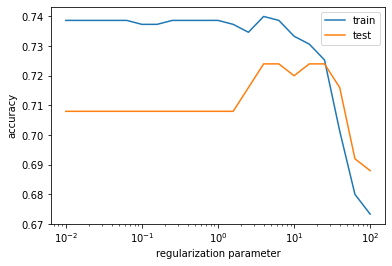

In [5]:
alpha = np.logspace(-2,2,21)  # 1 point

train_acc = np.zeros(len(alpha)) 
test_acc = np.zeros(len(alpha))

# 2 points
for i in range(len(alpha)):
    lr = LogisticRegression(penalty='l1',C = 1/alpha[i],solver='saga',max_iter=1e4) 
    lr.fit(X_train,y_train)

    train_acc[i] = accuracy_score(y_train,lr.predict(X_train))
    test_acc[i] = accuracy_score(y_test,lr.predict(X_test))

print(np.max(test_acc)) # 1 point
print(alpha[test_acc == np.max(test_acc)]) # 1 point

# 2 points
plt.plot(alpha,train_acc,label='train')
plt.plot(alpha,test_acc,label='test')
plt.xlabel('regularization parameter')
plt.ylabel('accuracy')
plt.legend()
plt.semilogx()
plt.show()


**Problem 2c** (1 point)

Perform l2 regularization on the data. The alpha values and all the other instructions are the same as in 2b.

0.72
[25.11886432 63.09573445]


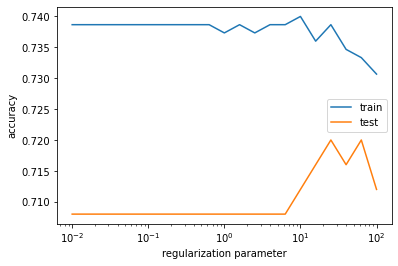

In [6]:

train_acc = np.zeros(len(alpha)) 
test_acc = np.zeros(len(alpha))

for i in range(len(alpha)):
    lr = LogisticRegression(penalty='l2',C = 1/alpha[i],solver='saga',max_iter=1e4) # 1 point
    lr.fit(X_train,y_train)

    train_acc[i] = accuracy_score(y_train,lr.predict(X_train))
    test_acc[i] = accuracy_score(y_test,lr.predict(X_test))

print(np.max(test_acc))
print(alpha[test_acc == np.max(test_acc)])

plt.plot(alpha,train_acc,label='train')
plt.plot(alpha,test_acc,label='test')
plt.xlabel('regularization parameter')
plt.ylabel('accuracy')
plt.legend()
plt.semilogx()
plt.show()



**Problem 2d** (10 points)

Let's train an elastic net now. The elastic net has two parameters: alpha and rho (the l1 ratio). The l1 ratio should be linearly spaced between 0 and 1 with 26 values in between. (1 point) Use the 'saga' solver. The reason we use the saga solver everywhere in Problem 2 is that it is the only solver in LogisticRegression that works with an elastic net. 

Calculate the train and test accuracy scores for all combinations of alpha and rho. 

Print the best test score and the corresponding alpha and rho values. 

Prepare heatmaps to show the train and test scores. Make sure that the data range covered by the two heatmaps are the same so you can easily compare the two heatmaps and you can identify the high bias and high variance regions. Label the plot and add a colorbar. Make the x and y ticks look pretty. 

Which of the four approaches gave you the best test score?

0.732
39.810717055349734 0.36


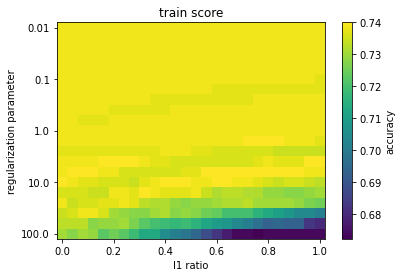

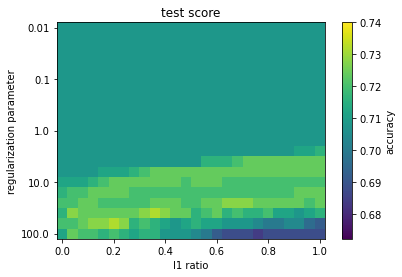

In [7]:
rho = np.linspace(0,1,26)

train_acc = np.zeros([len(alpha),len(rho)]) 
test_acc = np.zeros([len(alpha),len(rho)])
for i in range(len(alpha)):
    for j in range(len(rho)):
        lr = LogisticRegression(penalty='elasticnet',C = 1/alpha[i],solver='saga',l1_ratio=rho[j],max_iter=1e4)
        lr.fit(X_train,y_train)
        train_acc[i,j] = accuracy_score(y_train,lr.predict(X_train))
        test_acc[i,j] = accuracy_score(y_test,lr.predict(X_test))

print(np.max(test_acc)) # 1 point
indcs = np.unravel_index(np.argmax(test_acc),np.shape(test_acc))
print(alpha[indcs[0]],rho[indcs[1]]) # 2 points

plt.imshow(train_acc,vmin=np.min([np.min(train_acc),np.min(test_acc)]),vmax=np.max([np.max(train_acc),np.max(test_acc)]))
plt.xticks(np.arange(len(rho))[::5],rho[::5])
plt.yticks(np.arange(len(alpha))[::5],alpha[::5])
plt.xlabel('l1 ratio')
plt.ylabel('regularization parameter')
plt.title('train score')
plt.colorbar(label='accuracy')
plt.show()

plt.imshow(test_acc,vmin=np.min([np.min(train_acc),np.min(test_acc)]),vmax=np.max([np.max(train_acc),np.max(test_acc)]))
plt.xticks(np.arange(len(rho))[::5],rho[::5])
plt.yticks(np.arange(len(alpha))[::5],alpha[::5])
plt.xlabel('l1 ratio')
plt.ylabel('regularization parameter')
plt.title('test score')
plt.colorbar(label='accuracy')
plt.show()
